# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

**Заказчику важны:**
- качество предсказания;
- скорость предсказания;
- время обучения.  

In [1]:
#!pip install lightgbm

In [2]:
#!pip install xgboost

In [3]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import re
from datetime import datetime
import random as rd
import statistics as st

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error, make_scorer
import sklearn.metrics

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import seaborn as sns
from seaborn import kdeplot
import matplotlib.pyplot as plt

import math

import os

import time
import timeit
from datetime import datetime
from tqdm import tqdm
import os


import warnings
warnings.filterwarnings("ignore")

In [4]:
RS = 42
POROG = 2500

## Подготовка данных

In [5]:
# Загружаем данные
pth1 = '/datasets/autos.csv'
pth2 = 'autos.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'], dayfirst=True)
    
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'], dayfirst=True)
    
else:
    print('Ошибка загрузки данных, проверьте правильность пути, наличие файла')

### 1.1 Описание и анализ данных

In [6]:
display(df.head(), df.tail())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20,0,40764,2016-03-24 12:45:21


In [7]:
# Выводим общую информацию о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

В данных 354369 объектов и 16 признаков их описывающих.  
Типы данных приемлемы для анализа (для включенных в анализ признаков).  
Прсутствуют категориальные и количественные признаки.  
Названия столбцов соответствуют и корректны содержанию.  
Есть пропуски.  
Есть аномалии: у некоторых бъектов анкета создана ранее, чем зарегистрирован автомобиль.

In [8]:
# Функция, приводящая названия столбцов к нижнему регистру с подчеркиванием (snake style)
def snake_col (df):
    for idx, name in enumerate(df.columns):
        df.rename(columns={df.columns[idx]:'_'.join(re.findall('[A-Z][^A-Z]*',df.columns[idx])).lower()}, inplace=True)
    return df.columns

In [9]:
# Приведем названия столбцов к snake style
snake_col (df)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [10]:
#Смотрим результат замены
display(df.head(1), df.tail(1))

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20,0,40764,2016-03-24 12:45:21


In [11]:
# Проверка на явные дубликаты
# df.duplicated().sum()
df[df.duplicated()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15


In [12]:
# Доля задублированных строк 
d = len(df)-len(df.drop_duplicates())
p = round(100*d/len(df),2)
print(f'Количество явных дубликатов: {d} шт' \
     f'\nДоля явных дубликатов: {p}%')

Количество явных дубликатов: 4 шт
Доля явных дубликатов: 0.0%


In [13]:
# Пропуски в задублированных строках
df[df[df.duplicated()].isna()].count()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

В задублированных строках пропусков нет.

In [14]:
# Список качественных признаков
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type',
       'brand', 'repaired', 'date_created']

In [15]:
# Список количественных признаков
num_features = ['price', 'registration_year', 'power', 'kilometer', 'registration_month', \
                'postal_code', 'number_of_pictures']

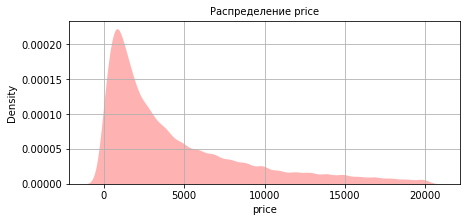

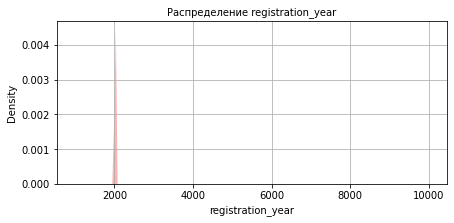

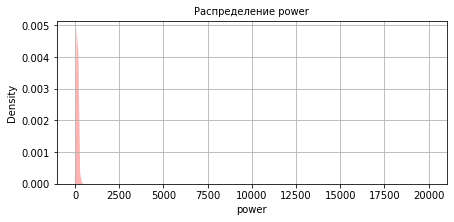

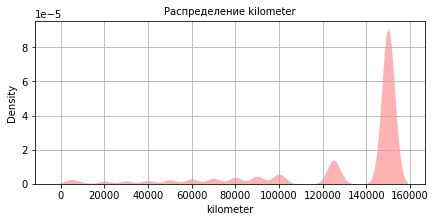

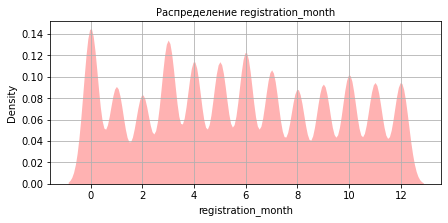

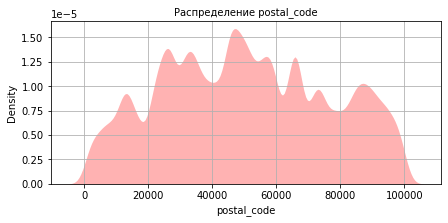

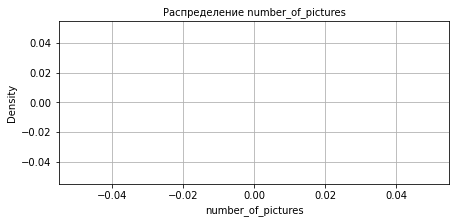

In [16]:
# Графики распределений количественных признаков
list(map(lambda x: [plt.figure(figsize=(7,3)), \
                    sns.kdeplot(data=df[x], color='red', fill= True , alpha= .3 , linewidth= 0), \
                    plt.grid(),  \
                    plt.title(f'Распределение {x}', \
                    fontsize=10), plt.show()], num_features))
plt.show()

Данные распределены ненормально.

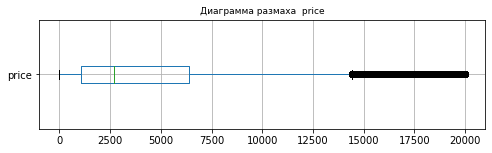

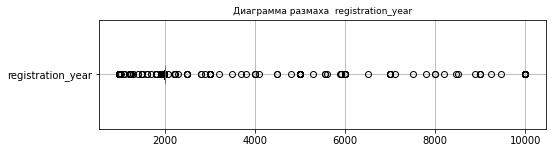

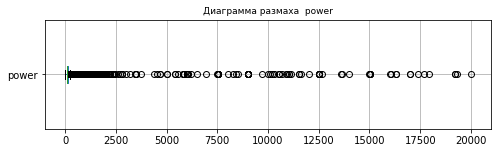

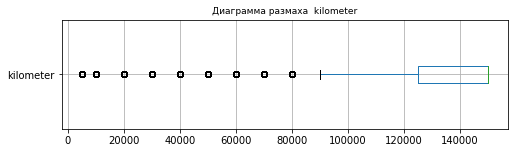

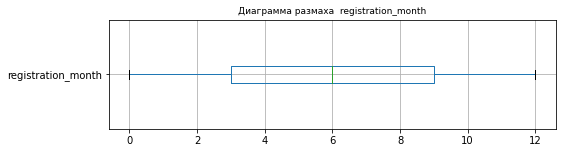

In [17]:
# Диаграммы размаха для количественных признаков 
list(map(lambda x: [plt.figure(figsize=(8, 2)), \
                    df[x].plot(kind='box', vert=False), \
                    plt.grid(), \
                    plt.title(f'Диаграмма размаха  {x}',fontsize=9)], \
                     num_features[:-2]))
plt.show()

Имеются выбросы и аномальные значения в значимых для анализа признаках. 
Например, в признаке 'registration_year' ненаступившие года.

In [18]:
# Посмотрим на статистики
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Пустая колонка number_of_pictures. Ее будем удалять.  
Признак price, power, registration_month имеют нулевые значения.

In [19]:
# Статистики даты создания анкеты
df['date_created'].describe()

count                  354369
unique                    109
top       2016-04-03 00:00:00
freq                    13719
first     2014-03-10 00:00:00
last      2016-04-07 00:00:00
Name: date_created, dtype: object

In [20]:
# Верхний порог для registration_year - год последней регистрации анкеты
reg_year_upthreshold = df['date_created'].dt.year.max()
print(f' Год последней регистрации анкеты - верхний порог для registration_year: {reg_year_upthreshold}г.')

 Год последней регистрации анкеты - верхний порог для registration_year: 2016г.


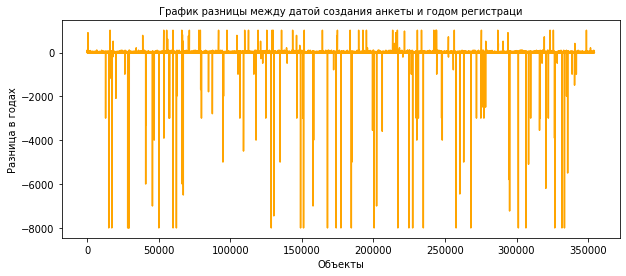

Количество объектов с ошибками в признаке "Год регистраци": 14530 шт
Доля ошибок: 4%


In [21]:
# График разницы между датой создания анкеты и годом регистраци
plt.figure(figsize=(10, 4))
diff = pd.Series(df['date_created'].dt.year - df['registration_year'])

diff.plot(color = 'orange')
plt.title('График разницы между датой создания анкеты и годом регистраци', fontsize=10)
plt.xlabel('Объекты',fontsize=10)
plt.ylabel('Разница в годах',fontsize=10)
plt.show()

diff = df[diff < 0]['registration_year'].count()

print(f'Количество объектов с ошибками в признаке "Год регистраци": {diff} шт\n' \
     f'Доля ошибок: {round(100*diff/len(df))}%')

Выявлены аномалии в данных: у 14530 бъектов дата регистрации автомобиля позже даты создания анкеты.  
Это 4% объектов. 

In [22]:
# Возможные пороги выбросов
features_out = []
iqr_up = []
iqr_down = []
q99 = []
q05 = []

[[
          features_out.append(x), \
          iqr_up.append(df[x].quantile(0.75) + 1.5 * (df[x].quantile(0.75) - df[x].quantile(0.25))), \
          iqr_down.append(df[x].quantile(0.25) - 1.5 * (df[x].quantile(0.75) - df[x].quantile(0.25))), \
          q99.append(df[x].quantile(0.99)), \
          q05.append(df[x].quantile(0.05)) \
] for x in num_features[:-2]]

print(f'\n Возможные пороги выбросов:')
thresholds = pd.DataFrame({'iqr_up': iqr_up, 'iqr_down':iqr_down, 'q99':q99, 'q05':q05}, \
                           index = features_out)
thresholds


 Возможные пороги выбросов:


,iqr_up,iqr_down,q99,q05
price,14425.0,-6975.0,18800.0,200.0
registration_year,2021.5,1985.5,2018.0,1992.0
power,254.0,-42.0,300.0,0.0
kilometer,187500.0,87500.0,150000.0,40000.0
registration_month,18.0,-6.0,12.0,0.0


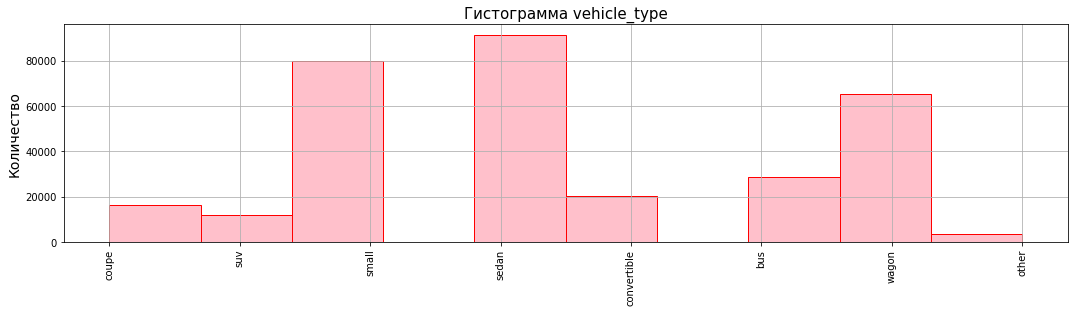

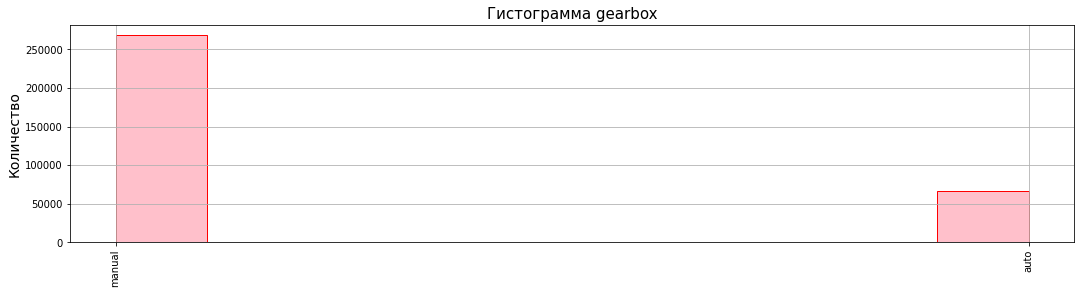

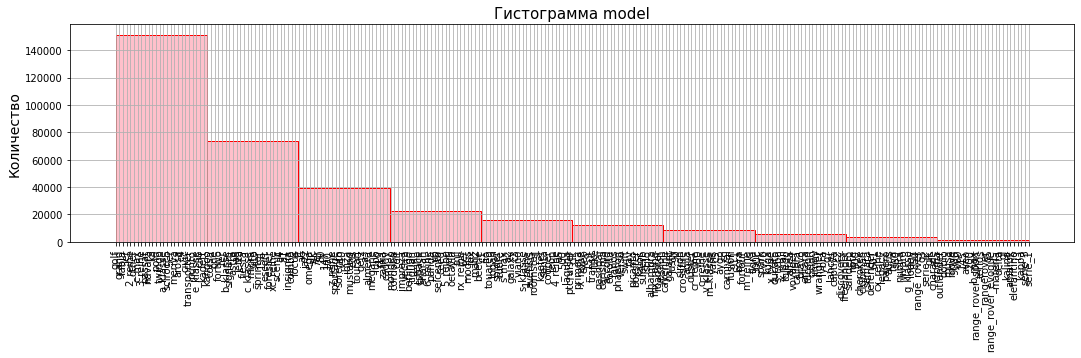

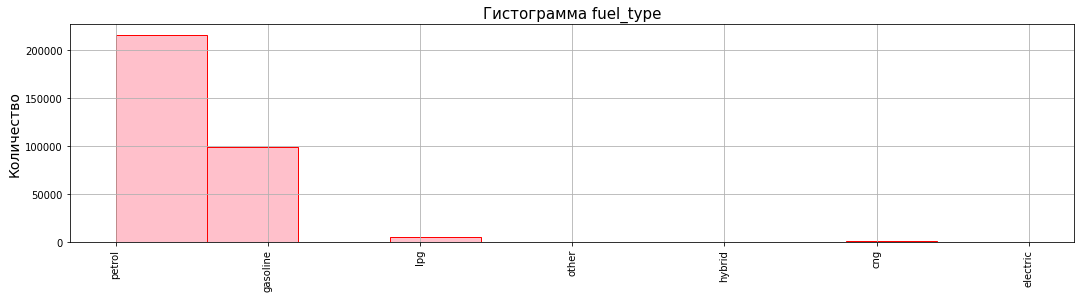

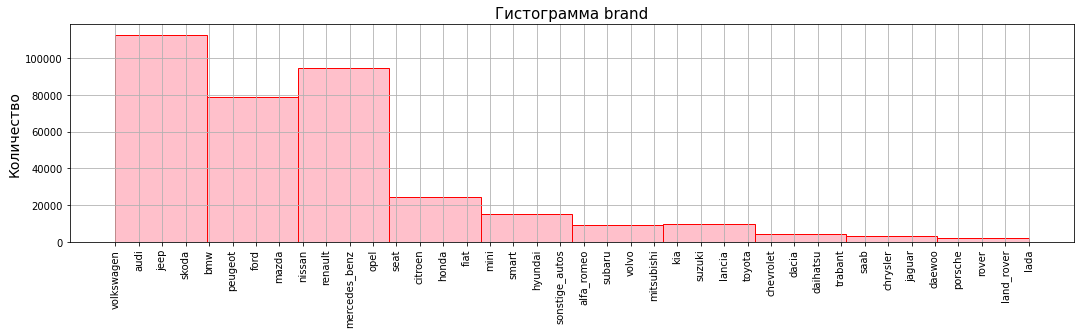

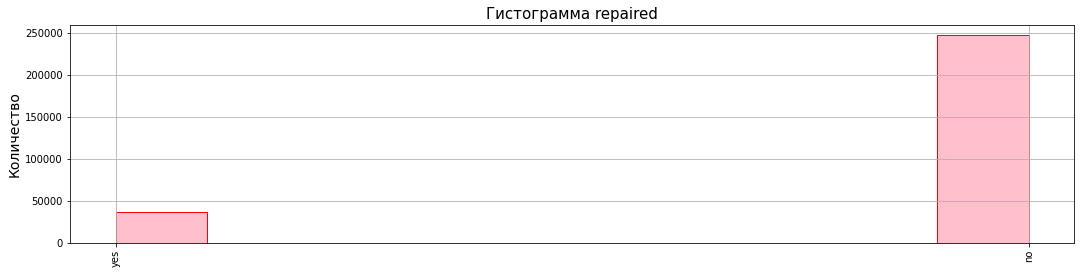

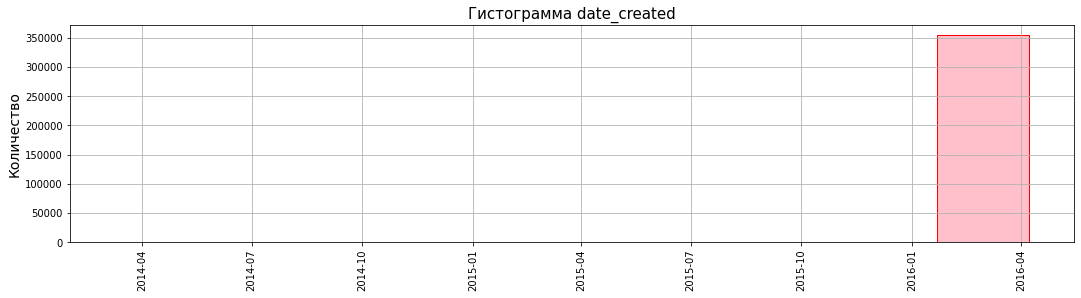

In [23]:
# Гистограммы качественных признаков
list(map(lambda c: [
                    plt.figure(figsize=(18, 4)),  \
                    plt.title(f'Гистограмма {c}',fontsize=15), \
                    df[c].hist(color='pink', label=c, ec='red'), 
                    plt.xlabel('', fontsize=14), \
                    plt.xticks(rotation=90, fontsize=10), \
                    plt.ylabel('Количество',fontsize=14), \
                    plt.show()], cat_features))
plt.show()

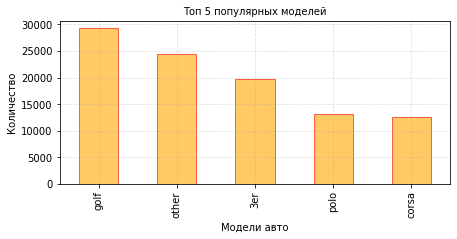

In [24]:
# Топ 5 популярных моделей
plt.figure(figsize=(7, 3))
plt.title('Топ 5 популярных моделей',fontsize=10)
df['model'].value_counts().sort_values(ascending=False)[:5].plot(kind='bar', color = 'orange', ec='red', alpha=0.6)
plt.grid(linestyle='--', alpha=0.4)
plt.xlabel('Модели авто',fontsize=10)
plt.ylabel('Количество',fontsize=10)
plt.xticks( fontsize=10)
plt.show()

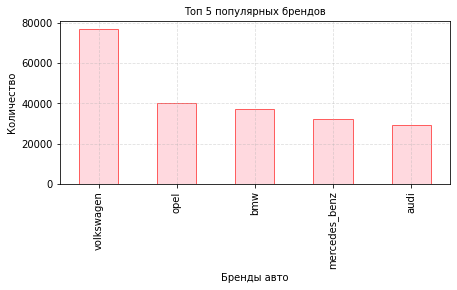

In [25]:
# Топ 5 популярных марок машин
plt.figure(figsize=(7, 3))
plt.title('Топ 5 популярных брендов',fontsize=10)
df['brand'].value_counts().sort_values(ascending=False)[:5].plot(kind='bar', color = 'pink', ec='red', alpha=0.6)
plt.grid(linestyle='--', alpha=0.4)
plt.xlabel('Бренды авто',fontsize=10)
plt.ylabel('Количество',fontsize=10)
plt.xticks(fontsize=10)
plt.show()

В данных больше количество моделей авто: в основном седаны и с маленьким кузовом, преимущественно с механической коробкой передач, с бензиновым типом потребления топлива, не бывавшие в ремонте.  
Топ 5 популярных моделей: golf, other, 3er, polo, corsa.  
Топ 5 популярных марок машин: volkswagen, opel, bmw, mercedes_benz, audi.  
Объявления созданы в период с 2014г. по апрель 2016г., преимущественно в 2016 году. 


In [26]:
# Выводим количество и долю (%) пропусков и количество нулевых значений в каждом столбце 
def count_na_null(df):
    na_sum = df.isna().sum()
    na_mean = round(df.isna().mean()*100, 2)

    # Подсчитываем количетво нулевых значений для каждого столбца
    is_null = []
    [is_null.append(df.loc[df[null] == 0, null].count()) for null in df.columns]
    #print(is_null)
    null_mean = 100*np.array(is_null)/len(df)
    #print(null_mean)
    data_info_in = display(pd.DataFrame({'Количество пропусков': na_sum, \
                                         'Количество пропусков в %': na_mean,  \
                                         'Количество нулевых значений': is_null, \
                                         'Количество нулевых значений в %': null_mean}) \
                           .style.format('{:.2f}').background_gradient("Reds"))

In [27]:
count_na_null(df)

,Количество пропусков,Количество пропусков в %,Количество нулевых значений,Количество нулевых значений в %
date_crawled,0.00,0.00,0.00,0.00
price,0.00,0.00,10772.00,3.04
vehicle_type,37490.00,10.58,0.00,0.00
registration_year,0.00,0.00,0.00,0.00
gearbox,19833.00,5.60,0.00,0.00
power,0.00,0.00,40225.00,11.35
model,19705.00,5.56,0.00,0.00
kilometer,0.00,0.00,0.00,0.00
registration_month,0.00,0.00,37352.00,10.54
fuel_type,32895.00,9.28,0.00,0.00


'Тепловая карта пропусков'

<AxesSubplot:>

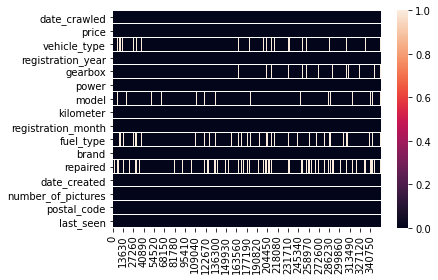

In [28]:
# Тепловая карта пропусков
display(f'Тепловая карта пропусков', sns.heatmap(df.isna().transpose()))
plt.show()

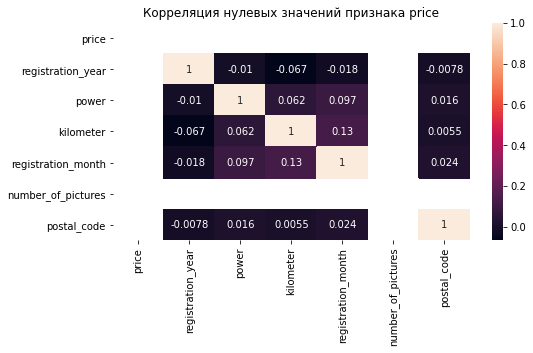

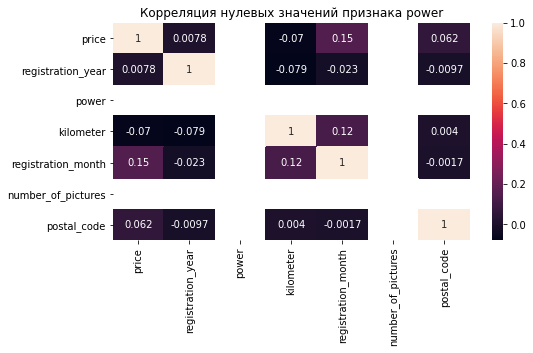

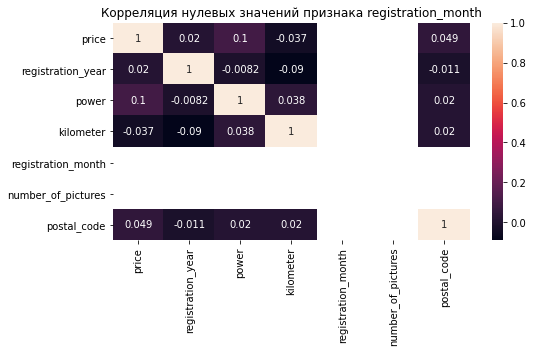

In [29]:
# Проверка на специфичность нулевых значений признаков для какого-то конкретного признака
# матрицей корреляции (тепловая карта)
null_corr = ['price', 'power', 'registration_month']

[[plt.figure(print(), figsize=(8, 4)), sns.heatmap(df.loc[df[x] == 0].corr(), annot=True), \
 plt.title(f'Корреляция нулевых значений признака {x}')] for x in null_corr]

plt.show()

In [30]:
# Проверка на специфичность нулевой цены для какого-то конкретного признака
list(map(lambda x: display(df.query('price == 0')[x].value_counts()[:10]), df.columns))

2016-03-24 14:56:22    2
2016-03-08 01:58:27    2
2016-03-27 22:55:05    2
2016-03-21 00:37:14    2
2016-03-05 22:25:21    2
2016-03-15 07:56:59    2
2016-03-17 22:38:13    2
2016-03-30 20:46:25    2
2016-04-03 13:40:37    2
2016-03-11 08:52:57    2
Name: date_crawled, dtype: int64

0    10772
Name: price, dtype: int64

sedan          2052
small          1813
wagon          1465
coupe           527
bus             430
convertible     338
suv             205
other           202
Name: vehicle_type, dtype: int64

2000    1418
1999     733
1998     721
1997     675
1995     654
2016     631
2005     585
2017     546
1996     471
2001     470
Name: registration_year, dtype: int64

manual    6878
auto      1416
Name: gearbox, dtype: int64

0      3865
75      704
90      453
60      432
150     420
101     338
115     214
170     209
125     203
116     185
Name: power, dtype: int64

golf      986
other     714
3er       582
polo      438
corsa     373
astra     334
passat    311
a4        258
5er       203
a6        173
Name: model, dtype: int64

150000    7672
5000      1025
125000     692
100000     436
90000      173
80000      147
20000      138
30000      104
70000      100
50000       79
Name: kilometer, dtype: int64

0     4471
6      661
5      618
4      569
1      556
3      550
7      535
12     519
8      493
10     489
Name: registration_month, dtype: int64

petrol      5587
gasoline    1552
lpg          144
other         34
cng           11
hybrid         6
electric       2
Name: fuel_type, dtype: int64

volkswagen        2600
opel              1401
bmw               1105
audi               882
ford               722
mercedes_benz      687
renault            538
sonstige_autos     527
fiat               311
peugeot            217
Name: brand, dtype: int64

no     3479
yes    2005
Name: repaired, dtype: int64

2016-03-25    410
2016-04-04    410
2016-03-09    400
2016-03-28    394
2016-03-21    394
2016-03-29    392
2016-03-20    384
2016-03-07    382
2016-03-19    378
2016-04-03    377
Name: date_created, dtype: int64

0    10772
Name: number_of_pictures, dtype: int64

15344    80
27432    28
52249    25
49477    24
58840    23
15345    23
27711    21
26624    20
27749    19
52477    18
Name: postal_code, dtype: int64

2016-04-07 05:46:27    3
2016-04-06 14:16:19    3
2016-04-06 16:46:57    3
2016-04-06 17:15:49    3
2016-04-05 20:44:47    3
2016-04-06 05:46:56    3
2016-04-06 04:16:45    3
2016-04-06 13:44:20    3
2016-04-07 00:16:35    3
2016-04-06 02:44:22    3
Name: last_seen, dtype: int64

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [31]:
# Проверка на специфичность нулевой цены для какого-то конкретного признака
df.loc[df['power'] == 0]
df.query('power == 0')['model'].mode()#[:10]
#list(map(lambda x: display(df.query('power == 0')[model].value_counts()[:10]), df.columns))

0    other
dtype: object

Имеют нулевые значения признаки:  
price - 3%  
power - 11%  
registration_month - 11%  
number_of_pictures - 100%  

Можно предположить, что, наиболее вероятно, нулевые значения в price автовладельцы могли намеренно выставить, чтобы увеличить вероятность просмотров их объявления, единичные случаи: возможно, продавали авто на металлолом (сгоревшее, после дтп и тп.), чтобы убрать с участка не за свой счет. Наибольшее количество нулей в цене у volkswagen.  

Нулевые значения мощности авто, могли также быть проставлены автовладельцами при продаже авто не на ходу (на запчасти) или незнании этой характеристики. 

Нули в registration_month могли возникнуть из-за ввода автовладельцем нуля при незнании месяца регистрации транспортного средства, также, возможно, есть особенность строки ввода - если месяц не введен - проставляется 0.
Нулевые значения рассматриваемых признаковнет не имеют специфики к конкретному признаку.  

Пропуски в признаках:  
vehicle_type - 11%  
gearbox - 5,6%  
model - 5,6%  
fuel_type - 9%  
repaired - 20%  

Пропуски в 'repaired' могут говорить о попытке автовладельцев скрыть факт ремонта машины.  
Пропуски в признаках fuel_type, model, gearbox, vehicle_type могут возникать при незполнении их автовладельцем из-за незнания этих характеристик.  
Также пропуски могут возникать при некорректной загрузке\выгрузке данных в базу или при ее обновлениях.

In [32]:
# Посмотрим уникальные значения в некоторых столбцах
unique_col = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired', \
              'power', 'registration_month', 'brand', 'postal_code']

In [33]:
list(map(lambda x: display(x, df[x].unique()), df[unique_col]))

'vehicle_type'

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

'gearbox'

array(['manual', 'auto', nan], dtype=object)

'model'

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

'fuel_type'

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

'repaired'

array([nan, 'yes', 'no'], dtype=object)

'power'

array([    0,   190,   163,    75,    69,   102,   109,    50,   125,
         101,   105,   140,   115,   131,    60,   136,   160,   231,
          90,   118,   193,    99,   113,   218,   122,   129,    70,
         306,    95,    61,   177,    80,   170,    55,   143,    64,
         286,   232,   150,   156,    82,   155,    54,   185,    87,
         180,    86,    84,   224,   235,   200,   178,   265,    77,
         110,   144,   120,   116,   184,   126,   204,    88,   194,
         305,   197,   179,   250,    45,   313,    41,   165,    98,
         130,   114,   211,    56,   201,   213,    58,   107,    83,
         174,   100,   220,    85,    73,   192,    68,    66,   299,
          74,    52,   147,    65,   310,    71,    97,   239,   203,
           5,   300,   103,   258,   320,    63,    81,   148,    44,
         145,   230,   280,   260,   104,   188,   333,   186,   117,
         141,    59,   132,   234,   158,    39,    92,    51,   135,
          53,   209,

'registration_month'

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

'brand'

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

'postal_code'

array([70435, 66954, 90480, ..., 38528, 38325, 31096])

[None, None, None, None, None, None, None, None, None]

Признаки vehicle_type, model, fuel_type имеют значения 'other'.  
Признаков неявных дублей нет.  
Признак postal_code неинформативен.

#### Мультиколлинеарные признаки

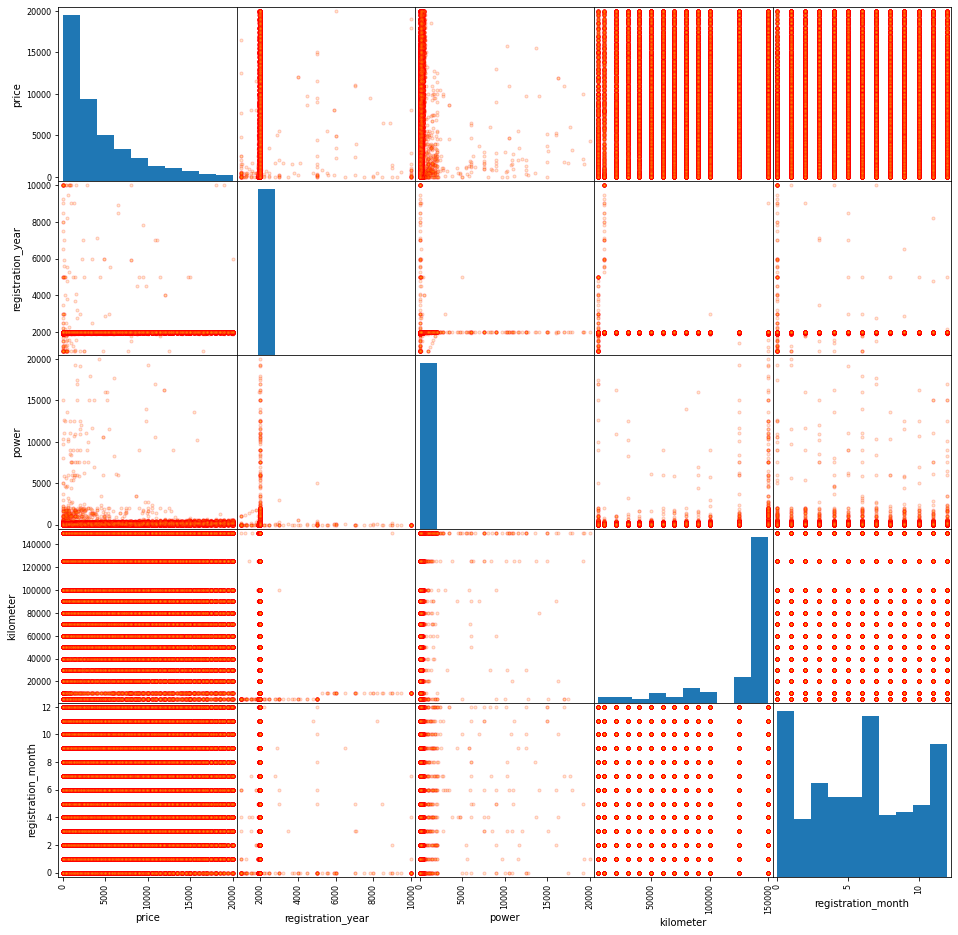

In [34]:
# Графики корреляции признаков
pd.plotting.scatter_matrix(df[num_features[:-2]], alpha=0.2, color='orange', ec='red', figsize=(16,16))
plt.show()

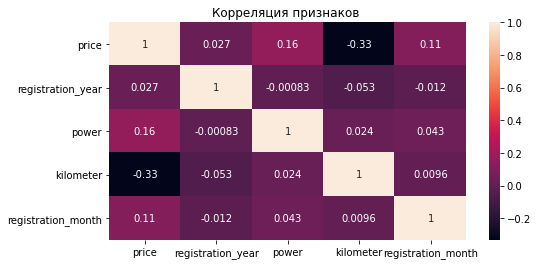

In [35]:
# Тепловая карта матрицы корреляции
plt.figure(print(), figsize=(8, 4)), sns.heatmap(df[num_features[:-2]].corr(), annot=True)
plt.title(f'Корреляция признаков ')
plt.show()

Мультиколлинеарных признаков нет.

#### Вывод 1.1
В данных 354369 объектов и 16 признаков их описывающих.  
Названия столбцов соответствуют и корректны содержанию.  
Типы данных приемлемы для анализа(для включенных в анализ признаков).  
Присутствуют категориальные и количественные признаки.  
Данные распределены ненормально, есть дубликаты, нулевые значения, аномалии, выбросы, пропуски и колонка из нулей number_of_pictures.  
Мультиколлинеарных признаков нет.  
В дубликатах пропусков нет.  
К удалению: 
	- явные дубликаты: 4 шт. (ничтжно малая доля); 
	- неинформативные для обучения признаки: 'date_crawled', 'registration_year', 'date_created', 'number_of_pictures', 'postal_code', last_seen'.  
    

В данных большое количество моделей авто: в основном седаны и с маленьким кузовом, преимущественно с механической коробкой 
передач, с бензиновым типом потребления топлива, не бывавшие в ремонте.  
Топ 5 популярных моделей: golf, other, 3er, polo, corsa.  
Топ 5 популярных марок машин: volkswagen, opel, bmw, mercedes_benz, audi.  
Объявления созданы в период с 2014г. по апрель 2016г., преимущественно в 2016 году.   

Имеют нулевые значения признаки:  
price - 3%  
power - 11%  
registration_month - 11%  
number_of_pictures - 100%  

Можно предположить, что, наиболее вероятно, нулевые значения в price автовладельцы могли намеренно выставить, чтобы увеличить вероятность просмотров их объявления, единичные случаи: возможно, продавали авто на металлолом (сгоревшее, после дтп и тп.), чтобы убрать с участка не за свой счет.  
Наибольшее количество нулей в цене у volkswagen.    
Нулевые значения мощности авто, могли также быть проставлены автовладельцами при продаже авто не на ходу (на запчасти) или незнании этой характеристики.  
Нули в registration_month могли возникнуть из-за ввода автовладельцем нуля при незнании месяца регистрации транспортного средства, также, возможно, есть особенность строки ввода - если месяц не введен - проставляется 0.  
Нулевые значения рассматриваемых признаковнет не имеют специфики к конкретному признаку.  

Пропуски в признаках:  
vehicle_type - 11%  
gearbox - 5,6%  
model - 5,6%  
fuel_type - 9%  
repaired - 20%  

Пропуски в 'repaired' могут говорить о попытке автовладельцев скрыть факт ремонта машины.  
Пропуски в признаках fuel_type, model, gearbox, vehicle_type могут возникать при незполнении их автовладельцем из-за незнания этих характеристик.  
Также пропуски могут возникать при некорректной загрузке\выгрузке данных в базу или при ее обновлениях.  
Признаки vehicle_type, model, fuel_type имеют значения 'other'.  
Признаков неявных дублей нет.  
Мультиколлинеарных признаков нет.  

Выявлены аномалии в данных: у 14530 бъектов дата регистрации автомобиля позже даты создания анкеты.   
Это 4% объектов. Заменим некорректные года медианой.

### 1.2 Предобработка данных

Заполним пропуски в  
vehicle_type, model, fuel_type, repaired - значениями other  
gearbox - модой по моделям  

Нулевые значения в price, power - их медианными значениями по моделям авто.    
Нулевые значения registration_month заполним случайным значением от 1 до 12.    

Выбросы обработаем так:  
price -  от 100 евро (до 99го квантиля)  
power - 5 - 5000 л.с.  
registration_year - от (2016-82)  до 2016г (в 18 лет человек уже может зарегистрировать авто)  

К удалению явные дубликаты и неинформативные признаки  
- полностью нулевой столбец number_of_pictures  
- 'date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'

#### Обработка дубликатов

In [36]:
# Удаление дубликатов
df = df.drop_duplicates()
print(f' Количество явных дубликатов после обработки: {df.duplicated().sum()}')


 Количество явных дубликатов после обработки: 0


#### Обработка пропусков и нулевых значений

In [37]:
# Замена пропусков в vehicle_type, model, fuel_type, repaired - значениями other
df = df.copy()
df[['vehicle_type', 'model', 'fuel_type', 'repaired']] = df[['vehicle_type', 'model', 'fuel_type', 'repaired']] \
    .apply(lambda x: x.fillna(value='other'))

# Проверка замены
#df[['vehicle_type', 'model', 'fuel_type', 'repaired']].isna().sum()

In [38]:
# Заполним нулевые значения registration_month случайным значением от 1 до 12
df['registration_month'] = [rd.randint(1, 12) if val == 0 else val for val in df['registration_month']]

In [39]:
df.head(3)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,other,1993,manual,0,golf,150000,1,petrol,volkswagen,other,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,other,2016-03-14,0,90480,2016-04-05 12:47:46


In [40]:
# Соотношение значений в gearbox до замены
print(f"Количество авто с автоматической коробкой передач до замены: {df.loc[df['gearbox'] == 'auto','gearbox'].count()}\n", \
      f"Количество авто с механической коробкой передач до замены: {df.loc[df['gearbox'] == 'manual','gearbox'].count()}")

Количество авто с автоматической коробкой передач до замены: 66283
 Количество авто с механической коробкой передач до замены: 268249


In [41]:
# Функция для замены пропусков и нулевых значений модой и медианным значением
# на входе - признак, который нужно заполнить, и флаг True - для заполнения пропусков медианой
# False -  модой 

def fill_na_null(feature_for_fill, median=True):
    
    try:
        if median:
            feature_filled_by = df.groupby('model')[feature_for_fill].median()
            for model, fill_value in feature_filled_by.iteritems():
                df.loc[ ((df[feature_for_fill] == 0) & (df['model'] == model)) \
                       | ((df[feature_for_fill].isnull()) & (df['model'] == model)), \
                       feature_for_fill] = fill_value
                if fill_value == 0:
                    df.loc[df[feature_for_fill] == 0] = df[feature_for_fill].median() # 2 модели имели моду 0 в power
                   
        else:
            feature_filled_by = df.groupby('model')[feature_for_fill].apply(lambda x: x.mode().iloc[0])
                                                                                                                                          
            for model, fill_value in feature_filled_by.iteritems():
                df.loc[df[feature_for_fill].isnull() & (df['model'] == model), feature_for_fill] = fill_value
                
    except:
        print('Ошибка - признак для заполнения указывается в кавычках, для категориальных признаков флаг False') #fc['registration_month'] = [rd.randint(1, 12) if val == 0 else val for val in dfc['registration_month']]
                                                                                                                # row, feature_filled_by in feature_filled_by.items():
                                                                                                                # df.loc[df[feature_for_fill].isna(), feature_for_fill] = feature_filled_by      

In [42]:
# Заполнение пропусков gearbox модой по моделям
fill_na_null('gearbox', median = False)

In [43]:
# Проверка соотношения значений
print(f" Количество авто с автоматической коробкой передач: {df.loc[df['gearbox'] == 'auto','gearbox'].count()}\n", \
      f"Количество авто с механической коробкой передач: {df.loc[df['gearbox'] == 'manual','gearbox'].count()}\n", \
      f"Количество пропусков в признаке gearbox: {df['gearbox'].isna().sum()}")

 Количество авто с автоматической коробкой передач: 67998
 Количество авто с механической коробкой передач: 286367
 Количество пропусков в признаке gearbox: 0


In [44]:
# проверка
#aa = df.groupby('model')['power'].agg('sum')
#aa.loc[aa == 0]

In [45]:
# Замена нулевых значений в price и power медианой по моделям
fill_na_null('price', median = True)
fill_na_null( 'power', median = True)

In [46]:
# Исходное количество объектов - проверка
len_df = len(df)
len_df

354365

In [47]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480.0,other,1993.0,manual,95.0,golf,150000.0,1.0,petrol,volkswagen,other,2016-03-24 00:00:00,0.0,70435.0,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300.0,coupe,2011.0,manual,190.0,other,125000.0,5.0,gasoline,audi,yes,2016-03-24 00:00:00,0.0,66954.0,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800.0,suv,2004.0,auto,163.0,grand,125000.0,8.0,gasoline,jeep,other,2016-03-14 00:00:00,0.0,90480.0,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500.0,small,2001.0,manual,75.0,golf,150000.0,6.0,petrol,volkswagen,no,2016-03-17 00:00:00,0.0,91074.0,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600.0,small,2008.0,manual,69.0,fabia,90000.0,7.0,gasoline,skoda,no,2016-03-31 00:00:00,0.0,60437.0,2016-04-06 10:17:21


#### Обработка выбросов

In [48]:
# Вспомним возмоные пороговые значения для удаления выбросов
thresholds

,iqr_up,iqr_down,q99,q05
price,14425.0,-6975.0,18800.0,200.0
registration_year,2021.5,1985.5,2018.0,1992.0
power,254.0,-42.0,300.0,0.0
kilometer,187500.0,87500.0,150000.0,40000.0
registration_month,18.0,-6.0,12.0,0.0


In [49]:
thresholds.loc['price', 'q05']

200.0

In [50]:
#df.loc[df['price'] > thresholds.loc['price', 'q99'], 'price'].count()/len_df*100
#df.loc[df['price'] < 100, 'price'].count()/len_df*100

In [51]:
# Удалим выбросы price от 100 евро до 99го квантиля

min_price = 100 #thresholds.loc['price', 'q05']
max_price = thresholds.loc['price', 'q99']
df = df.loc[(df['price'] > min_price) & (df['price'] < max_price)]
# проверка
df.loc[(df['price'] < min_price) & (df['price'] > max_price)]['price'].count()

0

In [52]:
# Удалим выбросы power в пределах 5 - 4000 - существуют машины с такими мощностями
min_power = 5
max_power = 4000 

df = df.loc[(df['power'] > min_power) & (df['power'] < max_power)]
# проверка
df.loc[(df['power'] < min_power) & (df['power'] > max_power)]['power'].count()
#len(df)

0

In [53]:
# Удалим выбросы registration_year от 1934 г. (2016-82) до 2016г (в 18 лет человек мог зарегистрировать авто)
min_year = 1934
max_year = 2016 

df = df.loc[(df['registration_year'] > min_year) & (df['power'] < max_year)]
# проверка
df.loc[(df['power'] < min_year) & (df['power'] > max_year)]['power'].count()
len(df) - df.loc[(df['registration_year'] > min_year) & (df['power'] < max_year)].count()
100*5283/len(df)

1.5447142585634712

#### Результрующая информация после обработки данных

In [54]:
# Функция подсчета % удаления данных от исходного размера данных
# на входе - исходная таблица после преобразований
def rate_clean(df_clean):
    return print(f'Всего удалено данных от исходного объема: {round(100 * (len_df - len(df_clean)) / len_df, 0)} %')

In [55]:
features_to_del = ['date_crawled', 'postal_code', 'number_of_pictures', 'last_seen']
try:
    for x in features_to_del:
        del df[x]
except:
    print('Признаки удалены')

In [56]:
# Проверка обработки нулевых значений и пропусков
count_na_null(df)

,Количество пропусков,Количество пропусков в %,Количество нулевых значений,Количество нулевых значений в %
price,0.00,0.00,0.00,0.00
vehicle_type,0.00,0.00,0.00,0.00
registration_year,0.00,0.00,0.00,0.00
gearbox,0.00,0.00,0.00,0.00
power,0.00,0.00,0.00,0.00
model,0.00,0.00,0.00,0.00
kilometer,0.00,0.00,0.00,0.00
registration_month,0.00,0.00,0.00,0.00
fuel_type,0.00,0.00,0.00,0.00
brand,0.00,0.00,0.00,0.00


In [57]:
# Проверка размера таблицы после преобразований
display(df.head(), df.shape)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created
0,480.0,other,1993.0,manual,95.0,golf,150000.0,1.0,petrol,volkswagen,other,2016-03-24 00:00:00
1,18300.0,coupe,2011.0,manual,190.0,other,125000.0,5.0,gasoline,audi,yes,2016-03-24 00:00:00
2,9800.0,suv,2004.0,auto,163.0,grand,125000.0,8.0,gasoline,jeep,other,2016-03-14 00:00:00
3,1500.0,small,2001.0,manual,75.0,golf,150000.0,6.0,petrol,volkswagen,no,2016-03-17 00:00:00
4,3600.0,small,2008.0,manual,69.0,fabia,90000.0,7.0,gasoline,skoda,no,2016-03-31 00:00:00


(342005, 12)

In [58]:
# Количество удаленных данных после обработки выбросов
rate_clean(df)

Всего удалено данных от исходного объема: 3.0 %


#### Вывод 1.2  
Заполнили пропуски в  
vehicle_type, model, fuel_type, repaired - значениями other  
gearbox - модой по моделям  

Нулевые значения в price, power - их медианными значениями по моделям авто.    
Нулевые значения registration_month заполним случайным значением от 1 до 12.    

Выбросы обработали так:  
price -  от 100 евро (до 99го квантиля)  
power - 5 - 5000 л.с.  
registration_year - от (2016-82)  до 2016г (в 18 лет человек уже может зарегистрировать авто)  

Удалили явные дубликаты и неинформативные признаки  
- полностью нулевой столбец number_of_pictures  
- 'date_crawled', 'number_of_pictures', 'postal_code', 'last_seen'

 - - - - 

###  1.3 Подготовка выборок

In [59]:
# Выделение целевого признака из данных

In [60]:
# Разделим данные на тестовую и обучающую выборки,
# для тестовой выборки - 20% данных из последних по дате создания анкеты.
h = int(0.2*len(df)) 
sorted_df = df.sort_values(by='date_created') 
test = sorted_df.tail(h)
train = sorted_df.head(-h)


In [61]:
# Удаляем еще один неинформативный более признак
del test['date_created'] 
del train['date_created'] 

In [62]:
display(train.head(3), train.tail(3), train.shape) 

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
61207,8999.0,other,2005.0,manual,120.0,147,125000.0,10.0,petrol,alfa_romeo,other
4001,6000.0,bus,1995.0,auto,200.0,other,150000.0,12.0,petrol,chevrolet,no
342275,10400.0,bus,1993.0,manual,110.0,ducato,30000.0,1.0,gasoline,fiat,other


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
71064,3200.0,wagon,2003.0,manual,140.0,a4,150000.0,3.0,gasoline,audi,no
337878,9800.0,wagon,2011.0,manual,184.0,clubman,40000.0,10.0,petrol,mini,yes
151086,18499.0,coupe,2006.0,manual,265.0,z_reihe,125000.0,12.0,petrol,bmw,no


(273604, 11)

In [63]:
display(test.head(3), test.tail(3), test.shape)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
151065,12900.0,wagon,2011.0,manual,116.0,c_max,100000.0,4.0,gasoline,ford,no
297006,1999.0,small,2003.0,manual,101.0,polo,150000.0,1.0,gasoline,volkswagen,no
241809,900.0,sedan,1996.0,manual,136.0,vectra,125000.0,11.0,petrol,opel,no


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
69760,999.0,small,1999.0,manual,99.0,other,125000.0,6.0,other,ford,no
27452,3999.0,coupe,1999.0,manual,170.0,3er,150000.0,6.0,petrol,bmw,no
81907,2745.0,sedan,2002.0,manual,101.0,golf,150000.0,7.0,gasoline,volkswagen,yes


(68401, 11)

In [64]:
# Выделим целевой признак из обучающей выборки
y_train = train['price']
X_train = train.drop('price', axis=1)
# проверка
display(y_train.head(3), y_train.tail(3), y_train.shape)
display(X_train.head(3), X_train.tail(3), X_train.shape)

61207      8999.0
4001       6000.0
342275    10400.0
Name: price, dtype: float64

71064      3200.0
337878     9800.0
151086    18499.0
Name: price, dtype: float64

(273604,)

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
61207,other,2005.0,manual,120.0,147,125000.0,10.0,petrol,alfa_romeo,other
4001,bus,1995.0,auto,200.0,other,150000.0,12.0,petrol,chevrolet,no
342275,bus,1993.0,manual,110.0,ducato,30000.0,1.0,gasoline,fiat,other


,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
71064,wagon,2003.0,manual,140.0,a4,150000.0,3.0,gasoline,audi,no
337878,wagon,2011.0,manual,184.0,clubman,40000.0,10.0,petrol,mini,yes
151086,coupe,2006.0,manual,265.0,z_reihe,125000.0,12.0,petrol,bmw,no


(273604, 10)

In [65]:
# Выделим целевой признак из тестовой выборки
y_test = test['price']
X_test = test.drop('price', axis=1)
# проверка
display(y_test.head(3), y_test.tail(3), y_test.shape)
display(X_test.head(3), X_test.tail(3), X_test.shape)

151065    12900.0
297006     1999.0
241809      900.0
Name: price, dtype: float64

69760     999.0
27452    3999.0
81907    2745.0
Name: price, dtype: float64

(68401,)

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
151065,wagon,2011.0,manual,116.0,c_max,100000.0,4.0,gasoline,ford,no
297006,small,2003.0,manual,101.0,polo,150000.0,1.0,gasoline,volkswagen,no
241809,sedan,1996.0,manual,136.0,vectra,125000.0,11.0,petrol,opel,no


,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
69760,small,1999.0,manual,99.0,other,125000.0,6.0,other,ford,no
27452,coupe,1999.0,manual,170.0,3er,150000.0,6.0,petrol,bmw,no
81907,sedan,2002.0,manual,101.0,golf,150000.0,7.0,gasoline,volkswagen,yes


(68401, 10)

In [66]:
#df.columns

In [67]:
# Переопределим список количественных признаков с учетом оставшихся признаков после предобработки данных
num_features2 = list(X_train.columns[X_train.columns.isin(num_features)]) #= list(filter(lambda col: col in df.columns, num_features)
num_features2

['registration_year', 'power', 'kilometer', 'registration_month']

In [68]:
# Переопределим список качественных признаков с учетом оставшихся признаков после предобработки данных
cat_features2 = list(X_train.columns[X_train.columns.isin(cat_features)])
cat_features2

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [69]:
num_features2

['registration_year', 'power', 'kilometer', 'registration_month']

In [70]:
cat_features2

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

#### Вывод 1.3   
Поготовлены выборки: тестовая - последние 20% данных по дате создания объявлений, обучающая - оставшиеся 80% данных.  
Удалили далее неинформативный признак  date_created.  
Определили список количественных и качественных признаков для создания предобработки для пайплайна.

## 2. Обучение моделей

In [71]:
# Функция для получения лучших параметров (из заданных для них диапазонов) указанной модели
# На вход подется модель машинного обучения и словарь параметров с заданным диапазоном, выборка для обучения
# На выходе получаем модель с лучшими параметрами по заданной метрике, обученную на выборке train, 
# и заданную метрику (rsme)

# функция для вычисления rsme
rmse = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

def best_model (model, param_dict, features, targets):
   
    model_rs = RandomizedSearchCV(estimator=model, \
                                  param_distributions=param_dict, \
                                  n_iter=10, cv=5, \
                                  n_jobs=-1, verbose=1, \
                                  scoring=rmse) 
    model_rs = model_rs.fit(features, targets)
    best_model = model_rs.best_estimator_
    best_params = model_rs.best_params_
    best_score = (-1)*model_rs.best_score_  
    fit_time = model_rs.refit_time_ # время обучения лучшей модели на всей выборке train
    # время предсказания на выборке train 
    start_time = time.time()
    predict = best_model.predict(features)
    end_time = time.time()
    predict_time = end_time - start_time
    return {'best_model': best_model, 'best_params': best_params, 'best_score': best_score, \
            'fit_time': fit_time, 'predict_time': predict_time}

In [72]:
# Словарь моделей
models = {
    'LGBMRegressor': LGBMRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(random_state=42),
    'RandomForestRegressor': RandomForestRegressor(random_state=42), 
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42),
    'LinearRegression': LinearRegression()
      
}
# Словарь обучаемых гиперпараметров для моделей #'lgbmregressor__num_leaves': [200],
params = {
    'LGBMRegressor': {'lgbmregressor__learning_rate': [0.08, 0.1], 
                      'lgbmregressor__n_estimators': [2, 220]}, 
                      
    'XGBRegressor': {'xgbregressor__learning_rate': [0.08, 0.1],
                     'xgbregressor__n_estimators': [2, 220]},
                    
    'RandomForestRegressor': {'randomforestregressor__max_depth': [4], 
                              'randomforestregressor__n_estimators': [2, 50]
                              },
    
    'DecisionTreeRegressor': {'decisiontreeregressor__max_depth': [2, 6]},                            
    
    'LinearRegression': {}  
}

In [73]:
#results_DecisionTreeRegressor = best_model(make_pipeline(preprocessor, models['DecisionTreeRegressor']) , params['DecisionTreeRegressor'], X_train, y_train)
#results_DecisionTreeRegressor

In [75]:
# Пайплайны для предобработки данных
num_transformer = make_pipeline(SimpleImputer(strategy='median'), MinMaxScaler())
cat_transformer = make_pipeline(SimpleImputer(strategy='constant', fill_value='other'), \
                                OneHotEncoder(handle_unknown='ignore', sparse = False, drop='first'))

preprocessor = ColumnTransformer(
    transformers=[('num', num_transformer, num_features2), \
                 ('cat', cat_transformer, cat_features2)])

In [76]:
# Создание словаря пайплайнов моделей
pipes = {}
for name, model in models.items():
    pipes[name] = make_pipeline(preprocessor, model)

In [77]:
%%time
# Подбираем лучшую модель ее гиперпараметры, оценку качества, время обучения, время предсказания 
results = {}
for name, pipe in pipes.items():
    results[name] = best_model(pipe, params[name], X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: user 6h 16min 17s, sys: 4min 37s, total: 6h 20min 55s
Wall time: 6h 22min 18s


### Вывод 2. 
Были подготовлены и обучены 4 модели с разными диапазонами гиперпараметров:  
'LGBMRegressor'  
'XGBRegressor'  
'RandomForestRegressor'  
'DecisionTreeRegressor'  
'LinearRegression

Модели были обучены с помощью созданной нами функции, которая выдает модель с лучшими гиперпараметрами по заданной заказчиком метрике RMSE, используя оптимизатор параметров RandomizedSearchCV, а также подсчитывающая время обучения лучшей модели и время ее предсказания на обучающей выборке.

## 3. Анализ моделей

### 3.1 Анализ моделей на обучающей выборке

In [78]:
# Результирующая таблица лучших моделей по качеству rmse, которые прошли по заданному заказчиком порогу
df_results = pd.DataFrame(results).T
df_results = df_results.loc[df_results['best_score'] < POROG]
df_results

,best_model,best_params,best_score,fit_time,predict_time
LGBMRegressor,"(ColumnTransformer(transformers=[('num',\n ...","{'lgbmregressor__n_estimators': 220, 'lgbmregr...",1633.489459,794.881965,6.506412
XGBRegressor,"(ColumnTransformer(transformers=[('num',\n ...","{'xgbregressor__n_estimators': 220, 'xgbregres...",1653.776131,1226.327946,6.565215
RandomForestRegressor,"(ColumnTransformer(transformers=[('num',\n ...","{'randomforestregressor__n_estimators': 50, 'r...",2451.400879,209.000905,2.758976
DecisionTreeRegressor,"(ColumnTransformer(transformers=[('num',\n ...",{'decisiontreeregressor__max_depth': 6},2231.321116,11.484994,2.062168


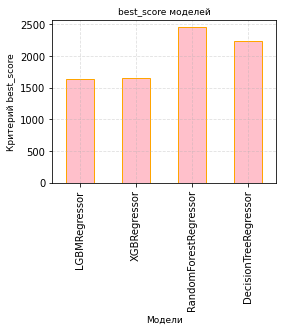

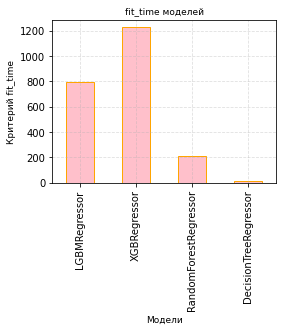

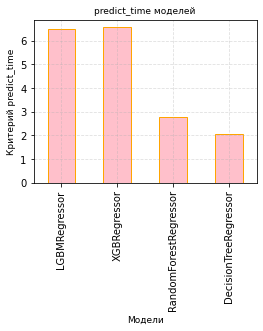

In [79]:
# Графики для сравнения критериев
list(map(lambda x:[plt.figure(figsize=(4,3)), 
                   df_results[x].plot(kind='bar', color = 'pink', ec='orange'), 
                   plt.grid(linestyle='--', alpha=0.4),
                   plt.title(f'{x} моделей', fontsize=9), 
                   plt.xlabel('Модели', fontsize=9), 
                   plt.ylabel(f'Критерий {x}', fontsize=9)], 
         list(df_results.columns[-3:])))
plt.show()

In [80]:
# лучшие модели по заданным критериям

best_score_idx = df_results['best_score'].astype(float).idxmin()
best_fit_time_idx = df_results['fit_time'].astype(float).idxmin()
best_predict_time_idx = df_results['predict_time'].astype(float).idxmin()

# параметры лучшей модели и ее значение по заданному критерию
best_score = [best_score_idx, 
              df_results.loc[best_score_idx, 'best_params'], 
              df_results.loc[best_score_idx, 'best_score'],
              df_results.loc[best_score_idx, 'best_model']
]
best_fit_time = [best_fit_time_idx, 
                 df_results.loc[best_fit_time_idx, 'best_params'], 
                 df_results.loc[best_fit_time_idx, 'fit_time'],
                 df_results.loc[best_fit_time_idx, 'best_model']
]   
best_predict_time = [best_predict_time_idx,
                     df_results.loc[best_predict_time_idx, 'best_params'],
                     df_results.loc[best_predict_time_idx, 'predict_time'],
                     df_results.loc[best_predict_time_idx, 'best_model']
]


In [81]:
# Таблица лучших моделей для каждого из критериев
df_bests = pd.DataFrame({'Критерии': ['score', 'fit_time', 'predict_time'], 
                         'Значение критерия': [round(best_score[2], 2), round(best_fit_time[2],2), 
                                               round(best_predict_time[2],2)],
                         'Имя модели': [best_score[0], best_fit_time[0], best_predict_time[0]],
                         'Гиперпараметры': [best_score[1], best_fit_time[1], best_predict_time[1]],
                         'Модель': [best_score[3], best_fit_time[3], best_predict_time[3]]
                  })
df_bests.set_index('Критерии', inplace=True)
df_bests

,Значение критерия,Имя модели,Гиперпараметры,Модель
Критерии,,,,
score,1633.49,LGBMRegressor,"{'lgbmregressor__n_estimators': 220, 'lgbmregr...","(ColumnTransformer(transformers=[('num',\n ..."
fit_time,11.48,DecisionTreeRegressor,{'decisiontreeregressor__max_depth': 6},"(ColumnTransformer(transformers=[('num',\n ..."
predict_time,2.06,DecisionTreeRegressor,{'decisiontreeregressor__max_depth': 6},"(ColumnTransformer(transformers=[('num',\n ..."


In [82]:
list(map(lambda x: [
    print(f'Лучшая модель по критерию {x}:\n {df_bests.loc[x,"Имя модели"]} \n {df_bests.loc[x,"Гиперпараметры"]}\n')], 
    list(df_bests.index)))

Лучшая модель по критерию score:
 LGBMRegressor 
 {'lgbmregressor__n_estimators': 220, 'lgbmregressor__learning_rate': 0.1}

Лучшая модель по критерию fit_time:
 DecisionTreeRegressor 
 {'decisiontreeregressor__max_depth': 6}

Лучшая модель по критерию predict_time:
 DecisionTreeRegressor 
 {'decisiontreeregressor__max_depth': 6}



[[None], [None], [None]]

#### Вывод 3.1
Врезультате анализа моделей на обучающей выборке выяснилось, что одновременно всем трем критерям заказчика не удовлетворяет ни одна модель. Предложим заказчику лучшиие в каждом критерии для оценки их на тесте. Из 5 моделей 4 прошли по заданному заказчиком порогу качества rmse в 2500: LGBMRegressor, RandomForestRegressor и DecisionTreeRegressor. Линейная регрессия не справилась.

Лучшая модель по критерию score:
 LGBMRegressor 
 {'lgbmregressor__n_estimators': 220, 'lgbmregressor__learning_rate': 0.1}

Лучшая модель по критерию fit_time:
 DecisionTreeRegressor 
 {'decisiontreeregressor__max_depth': 6}

Лучшая модель по критерию predict_time:
 DecisionTreeRegressor 
 {'decisiontreeregressor__max_depth': 6}

Поэтому оценку качества на тестовой выборке проводим для лучших моделей каждого критерия:  
LGBMRegressor - для критериев точность  
DecisionTreeRegressor - для критерия скорости обучения и предсказания

### 3.2 Анализ моделей на тестовой выборке

In [83]:
#df_bests = df_bests.drop(df_bests.loc['Критерии' == 'fit_time'], axis=0)#loc[df_bests['Модель'].unique()]
df_bests = df_bests.drop(df_bests.index[1])
df_bests

,Значение критерия,Имя модели,Гиперпараметры,Модель
Критерии,,,,
score,1633.49,LGBMRegressor,"{'lgbmregressor__n_estimators': 220, 'lgbmregr...","(ColumnTransformer(transformers=[('num',\n ..."
predict_time,2.06,DecisionTreeRegressor,{'decisiontreeregressor__max_depth': 6},"(ColumnTransformer(transformers=[('num',\n ..."


In [84]:
# Предсказания модели на тестовой выборке, потенциально подходящих для заказчика по заданным им критериям
score_model_predict = df_bests.loc['score', 'Модель'].predict(X_test)
predict_time_model_predict = df_bests.loc['predict_time', 'Модель'].predict(X_test)
#fit_time_model_predict = df_bests.loc['fit_time', 'Модель'].predict(X_test)

In [85]:
# Оценка качества моделей по метрике rmse
rmse_score_model = round(np.sqrt(mean_squared_error(y_test, score_model_predict)),0)
rmse_predict_time_model = round(np.sqrt(mean_squared_error(y_test, predict_time_model_predict)),0)
#rmse_fit_time_model = round(np.sqrt(mean_squared_error(y_test, fit_time_model_predict)),0)

In [86]:
# Предсказания базовой модели на тестовой выборке 
dummy_model = make_pipeline(preprocessor, DummyRegressor(strategy='mean'))
dummy_model.fit(X_train, y_train)
dummy_model_predict = dummy_model.predict(X_test)
rmse_dummy = round(np.sqrt(mean_squared_error(y_test, dummy_model_predict)),0)

,model,rmse_test
0,LGBMRegressor,1648.0
1,DecisionTreeRegressor,2253.0
2,DummyRegressor,4304.0


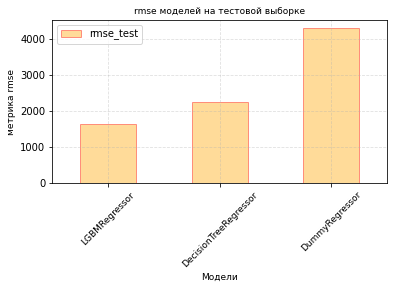

In [87]:
# rmse на тестовой выборке

rmse_dct = {'model': list(map(lambda x: df_bests.loc[x, 'Имя модели'], list(df_bests.index)))+['DummyRegressor'],
            'rmse_test': [rmse_score_model, rmse_predict_time_model]+[rmse_dummy]
}
rmse_dct = pd.DataFrame(rmse_dct)

#rmse_dct.set_index('Модель', inplace=False)
display(rmse_dct)

ax = rmse_dct.plot(kind='bar', alpha=0.4, color='orange', ec='red', figsize=(6,3))
ax.set_xticklabels(rmse_dct.loc[:,'model'], rotation=45, fontsize=9)
plt.grid(linestyle='--', alpha=0.4)
plt.title(f'rmse моделей на тестовой выборке', fontsize=9) 
plt.xlabel('Модели', fontsize=9) 
plt.ylabel(f'метрика rmse', fontsize=9) 
plt.show()

In [88]:
# Проверка моделей на адекватность
[print(f'Модель {x} прошла тест на адекватность') \
 if (rmse_dct.loc[rmse_dct['model'] == x]['rmse_test'].values[0] < \
     rmse_dct.loc[rmse_dct['model'] == 'DummyRegressor']['rmse_test'].values[0]) \
 else print(f'Модель {x} не прошла тест на адекватность') for x in list(rmse_dct['model'])[0:3]]

Модель LGBMRegressor прошла тест на адекватность
Модель DecisionTreeRegressor прошла тест на адекватность
Модель DummyRegressor не прошла тест на адекватность


[None, None, None]

#### Вывод 3.2 
Сделаны предсказания выбранных лучших по криериям заказчика моделей на тестовой выборке и оценены метрикой rmse.  
Лучший результат по метрике rmse показала модель:  
LGBMRegressor   
{'lgbmregressor__n_estimators': 220, 'lgbmregressor__learning_rate': 0.1}.  
Все потенциально подходящие по критериям заказчика модели прошли тест на адекватность.  
Заказчику можно предложить ранжировать приоритет критериев и использовать найденную модель для предсказания цены на автомобиль.

## Вывод
Вывод 1.1  

В данных 354369 объектов и 16 признаков их описывающих.  
Названия столбцов соответствуют и корректны содержанию.  
Типы данных приемлемы для анализа(для включенных в анализ признаков).  
Присутствуют категориальные и количественные признаки.  
Данные распределены ненормально, есть дубликаты, нулевые значения, аномалии, выбросы, пропуски и колонка из нулей number_of_pictures.  
Мультиколлинеарных признаков нет.  
В дубликатах пропусков нет.  
К удалению: 
	- явные дубликаты: 4 шт. (ничтжно малая доля); 
	- неинформативные для обучения признаки: 'date_crawled', 'registration_year', 'date_created', 'number_of_pictures', 'postal_code', last_seen'.  
    

В данных большое количество моделей авто: в основном седаны и с маленьким кузовом, преимущественно с механической коробкой 
передач, с бензиновым типом потребления топлива, не бывавшие в ремонте.  
Топ 5 популярных моделей: golf, other, 3er, polo, corsa.  
Топ 5 популярных марок машин: volkswagen, opel, bmw, mercedes_benz, audi.  
Объявления созданы в период с 2014г. по апрель 2016г., преимущественно в 2016 году.   

Имеют нулевые значения признаки:  
price - 3%  
power - 11%  
registration_month - 11%  
number_of_pictures - 100%  

Можно предположить, что, наиболее вероятно, нулевые значения в price автовладельцы могли намеренно выставить, чтобы увеличить вероятность просмотров их объявления, единичные случаи: возможно, продавали авто на металлолом (сгоревшее, после дтп и тп.), чтобы убрать с участка не за свой счет.  
Наибольшее количество нулей в цене у volkswagen.    
Нулевые значения мощности авто, могли также быть проставлены автовладельцами при продаже авто не на ходу (на запчасти) или незнании этой характеристики.  
Нули в registration_month могли возникнуть из-за ввода автовладельцем нуля при незнании месяца регистрации транспортного средства, также, возможно, есть особенность строки ввода - если месяц не введен - проставляется 0.  
Нулевые значения рассматриваемых признаковнет не имеют специфики к конкретному признаку.  

Пропуски в признаках:  
vehicle_type - 11%  
gearbox - 5,6%  
model - 5,6%  
fuel_type - 9%  
repaired - 20%  

Пропуски в 'repaired' могут говорить о попытке автовладельцев скрыть факт ремонта машины.  
Пропуски в признаках fuel_type, model, gearbox, vehicle_type могут возникать при незполнении их автовладельцем из-за незнания этих характеристик.  
Также пропуски могут возникать при некорректной загрузке\выгрузке данных в базу или при ее обновлениях.  
Признаки vehicle_type, model, fuel_type имеют значения 'other'.  
Признаков неявных дублей нет.  
Мультиколлинеарных признаков нет.  

Выявлены аномалии в данных: у 14530 бъектов дата регистрации автомобиля позже даты создания анкеты.   
Это 4% объектов. Заменим некорректные года медианой.    

Вывод 1.2  
Заполнили пропуски в  
vehicle_type, model, fuel_type, repaired - значениями other  
gearbox - модой по моделям  

Нулевые значения в price, power - их медианными значениями по моделям авто.    
Нулевые значения registration_month заполним случайным значением от 1 до 12.    

Выбросы обработали так:  
price -  от 100 евро (до 99го квантиля)  
power - 5 - 5000 л.с.  
registration_year - от (2016-82)  до 2016г (в 18 лет человек уже может зарегистрировать авто)  

Удалили явные дубликаты и неинформативные признаки  
- полностью нулевой столбец number_of_pictures  
- 'date_crawled', 'number_of_pictures', 'postal_code', 'last_seen'  

Вывод 1.3   
Поготовлены выборки: тестовая - последние 20% данных по дате создания объявлений, обучающая - оставшиеся 80% данных.  
Удалили далее неинформативный признак  date_created.  
Определили список количественных и качественных признаков для создания предобработки для пайплайна.  

Вывод 2.  
Были подготовлены и обучены 5 моделей с разными диапазонами гиперпараметров:  
'LGBMRegressor'  
'XGBRegressor'  
'RandomForestRegressor'  
'DecisionTreeRegressor'  
'LinearRegression  

По заданию заказчика были построены модели, которые определяют рыночную стоимость автомобиля, необходимую для приложения заказчика. Они были обучены на предоставленых заказчиком данных о технических характеристиках, комплектации и ценах других автомобилей. Заказчик определил критерии модели: качество предсказания; время обучения модели; время предсказания модели. 
Обучение проходило с помощью созданной нами функции, которая выдает модель с лучшими гиперпараметрами по заданной заказчиком метрике RMSE, используя оптимизатор параметров RandomizedSearchCV, а также подсчитывающая время обучения лучшей модели и время ее предсказания на обучающей выборке.  
Врезультате анализа моделей на обучающей выборке выяснилось, что одновременно всем трем критерям заказчика не удовлетворяет ни одна модель. Предложено заказчику лучшиие в каждом критерии для оценки их на тесте.  
Из 5 моделей 4 прошли по заданному заказчиком порогу качества rmse в 2500: LGBMRegressor, RandomForestRegressor и DecisionTreeRegressor. Линейная регрессия не справилась.  

Лучшая модель по критерию score:
 LGBMRegressor 
 {'lgbmregressor__n_estimators': 220, 'lgbmregressor__learning_rate': 0.1}

Лучшая модель по критерию fit_time:
 DecisionTreeRegressor 
 {'decisiontreeregressor__max_depth': 6}

Лучшая модель по критерию predict_time:
 DecisionTreeRegressor 
 {'decisiontreeregressor__max_depth': 6}

Поэтому оценку качества на тестовой выборке проводим для лучших моделей каждого критерия:  
LGBMRegressor - для критериев точность  
DecisionTreeRegressor - для критерия скорости обучения и предсказания  

Сделаны предсказания выбранных лучших по криериям заказчика моделей на тестовой выборке и оценены метрикой rmse.   
Все потенциально подходящие по критериям заказчика модели прошли тест на адекватность.  

Лучший результат по метрике rmse показала модель:  
LGBMRegressor   
{'lgbmregressor__n_estimators': 220, 'lgbmregressor__learning_rate': 0.1}.   
Качество по rmse: 1633.49  
время обучения: 794.88  
время предсказания: 6.51
  
Заказчику можно предложить ранжировать приоритет критериев и использовать для приложения найденную модель предсказания цен на автомобили.